In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'


In [2]:
%pwd
%cd ..
%cd src
%pwd

/home/kyudan/AnomLLM
/home/kyudan/AnomLLM/src


'/home/kyudan/AnomLLM/src'

In [3]:
#Please edit the BASE_DIR on your situation.

BASE_DIR = "/home/kyudan/AnomLLM"

In [4]:
def sample_time_series(time_series, num_samples):

    values = time_series.split()
    
    # 앞에서부터 num_samples개만 선택
    sampled_values = values[:num_samples]
    
    return " ".join(sampled_values)


def make_component_prompt_with_sample(time_series, num_samples):
    """
    원하는 샘플 수로 시계열을 샘플링하고 해당 길이에 맞는 프롬프트를 생성합니다.
    
    Args:
        time_series (str): 원본 시계열 데이터 문자열
        num_samples (int): 실험에 사용할 샘플 수 (100, 200, 300 등)
    
    Returns:
        str: 트렌드 컴포넌트 추출을 위한 프롬프트
    """
    # 앞에서부터 원하는 샘플 수만큼만 추출
    sampled_series = sample_time_series(time_series, num_samples)
    
    # 프롬프트 생성
    COMPONENT_PROMPT = f"""Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
{sampled_series}

CRITICAL INSTRUCTION: Extract ONLY the trend component from this time series.

EXACT LENGTH REQUIREMENT: Your output MUST contain EXACTLY {num_samples} values - one trend value for EACH value in the original time series.

DECIMAL PRECISION: Maintain the same level of precision as the original data (2 decimal places). Example: If original values are like "-0.63", "-0.57", trend values should also have 2 decimal places like "-0.62", "-0.61".

Count the values in the original data carefully. The original has exactly {num_samples} values, so your trend component must also have exactly {num_samples} values, no more and no less.

Return your answer as space-separated numbers in the following JSON format:
{{
  "Trend": "value1 value2 value3 ... value{num_samples}"
}}

DO NOT abbreviate or shorten the output. Include EVERY single trend value with 2 decimal places.
"""
    return COMPONENT_PROMPT

In [5]:
from prompt import LIMIT_PROMPT,PROMPT, time_series_to_str


def create_component_prompt(
        idx,
        series,
        num_samples,
):

    messages = [
        {
            "role": "user",
            "content": make_component_prompt_with_sample(time_series_to_str(series[idx]), num_samples,)
        }
    ]
    if idx == 0:
        print(messages[0]["content"])
    return {
        "messages": messages,
        "temperature": 0.4,
        "stop": ["''''", " – –", "<|endoftext|>", "<|eot_id|>"]
    }


In [8]:
from openai_api import send_openai_request
import json
import time
import os
from loguru import logger
from data.synthetic import SyntheticDataset
import pandas as pd



def online_AD_with_retries_component(
    model_name: str,
    pcl_name: str,
    #data_name: str,
    #request_func: callable,
    #variant: str = "standard",
    num_retries: int = 4,
    num_samples: int = 100,
    restrict_to_10_samples: bool = False,
):
    df = pd.read_pickle(pcl_name)

    # Initialize dictionary to store results
    results = {}

    # Configure logger
    log_fn = f"logs/synthetic/{pcl_name}/{model_name}/" + ".log"
    logger.add(log_fn, format="{time} {level} {message}", level="INFO")
    results_dir = f'{BASE_DIR}/results/synthetic/{pcl_name}/{model_name}/'
    jsonl_fn = os.path.join(results_dir + f'component_2_num_samples-{num_samples}.jsonl')
    os.makedirs(results_dir, exist_ok=True)

    if os.path.exists(jsonl_fn):
        logger.error(f"Results file '{jsonl_fn}' already exists. Please delete it first to avoid duplicate entries.")
        print(f"Results file '{jsonl_fn}' already exists. Please delete it and run again.")
        return None

    for i in (range(1,11) if restrict_to_10_samples else range(1, len(df)+1)):
        custom_id = f"{pcl_name}_{model_name}_{str(i).zfill(5)}"
        series = df['series_values']

        # Perform anomaly detection with exponential backoff
        for attempt in range(num_retries):
            try:
                request = create_component_prompt(i-1, series, num_samples)
                start = time.time()
                response = send_openai_request(request, model_name)
                end = time.time()
                print(f"time: {end-start}")
                # Write the result to jsonl
                with open(jsonl_fn, 'a') as f:
                    json.dump({'custom_id': custom_id, 'request': request, 'response': response}, f)
                    f.write('\n')
                # If successful, break the retry loop
                break
            except Exception as e:
                if "503" in str(e):  # Server not up yet, sleep until the server is up again
                    while True:
                        logger.debug("503 error, sleep 30 seconds")
                        time.sleep(30)
                        try:
                            response = send_openai_request(request, model_name)
                            break
                        except Exception as e:
                            if "503" not in str(e):
                                break
                else:
                    logger.error(e)
                    # If an exception occurs, wait and then retry
                    wait_time = 2 ** (attempt + 3)
                    logger.debug(f"Attempt {attempt + 1} failed. Waiting for {wait_time} seconds before retrying...")
                    time.sleep(wait_time)
                    continue
        else:
            logger.error(f"Failed to process {custom_id} after {num_retries} attempts")

In [9]:
pcl_name = "../data/synthetic/component_series_400.pkl"
for num in [100,200,300,400,500,600,700,800,900,1000]:
    online_AD_with_retries_component('gemini-1.5-flash', pcl_name, num_samples=num, restrict_to_10_samples = True)


2025-04-11 21:17:18.436 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.83 -0.8 -0.76 -0.71 -0.66 

2025-04-11 21:17:23.047 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.6101930141448975


2025-04-11 21:17:27.658 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.610059976577759


2025-04-11 21:17:32.028 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.368760585784912


2025-04-11 21:17:36.607 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.577692270278931


2025-04-11 21:17:41.193 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.584400177001953


2025-04-11 21:17:45.574 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.379581689834595


2025-04-11 21:17:50.509 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.9342310428619385


2025-04-11 21:17:55.145 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.634078025817871


2025-04-11 21:17:59.686 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.539850234985352


2025-04-11 21:18:04.130 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 4.4115893840789795
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.8

2025-04-11 21:18:13.638 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 9.49418330192566


2025-04-11 21:18:23.106 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 9.465697288513184


2025-04-11 21:18:32.274 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 9.167095184326172


2025-04-11 21:18:42.216 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 9.941139936447144


2025-04-11 21:18:50.559 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.342690706253052


2025-04-11 21:18:59.338 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.778201341629028


2025-04-11 21:19:08.286 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.946141004562378


2025-04-11 21:19:17.825 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 9.538357973098755


2025-04-11 21:19:26.647 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.819388628005981


2025-04-11 21:19:35.428 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 8.75694751739502
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.83 

2025-04-11 21:19:48.276 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.847115993499756


2025-04-11 21:20:01.342 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.065346240997314


2025-04-11 21:20:13.690 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.346295595169067


2025-04-11 21:20:26.508 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.817603826522827


2025-04-11 21:20:39.475 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.964382648468018


2025-04-11 21:20:51.587 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.112022399902344


2025-04-11 21:21:04.577 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.989100217819214


2025-04-11 21:21:16.915 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.336898565292358


2025-04-11 21:21:29.403 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.487473249435425


2025-04-11 21:21:42.055 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.633949518203735
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.8

2025-04-11 21:22:14.199 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 32.14241886138916


2025-04-11 21:22:46.970 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 32.76897597312927


2025-04-11 21:23:05.768 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 18.795347213745117


2025-04-11 21:23:24.759 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 18.9904727935791


2025-04-11 21:23:56.700 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 31.94010090827942


2025-04-11 21:24:12.002 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.301140069961548


2025-04-11 21:24:23.927 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 11.923164367675781


2025-04-11 21:24:39.679 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.751399278640747


2025-04-11 21:24:55.463 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 15.78272294998169


2025-04-11 21:25:28.256 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 32.755455493927
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.83 -

2025-04-11 21:25:41.261 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.992032289505005


2025-04-11 21:26:00.386 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 19.12596321105957


2025-04-11 21:26:13.311 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.924256324768066


2025-04-11 21:26:26.076 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.762762308120728


2025-04-11 21:26:39.014 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.935424566268921


2025-04-11 21:26:51.151 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.134356260299683


2025-04-11 21:27:07.479 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 16.327627658843994


2025-04-11 21:27:20.152 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.670609474182129


2025-04-11 21:27:33.134 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.981108665466309


2025-04-11 21:27:45.961 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.811294317245483
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.8

2025-04-11 21:27:59.855 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.89078664779663


2025-04-11 21:28:22.432 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.574668645858765


2025-04-11 21:28:35.002 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.569846630096436


2025-04-11 21:28:48.478 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.474691390991211


2025-04-11 21:29:01.480 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.001127481460571


2025-04-11 21:29:13.997 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.516327142715454


2025-04-11 21:29:27.163 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.165313482284546


2025-04-11 21:29:40.863 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.697717428207397


2025-04-11 21:30:03.740 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.87385606765747


2025-04-11 21:30:17.205 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.452446699142456
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.8

2025-04-11 21:30:40.106 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.899051904678345


2025-04-11 21:31:02.738 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.63117742538452


2025-04-11 21:31:25.534 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.7945077419281


2025-04-11 21:31:48.184 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.649568796157837


2025-04-11 21:32:04.258 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 16.07327914237976


2025-04-11 21:32:16.585 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 12.325931787490845


2025-04-11 21:32:36.924 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 20.338120460510254


2025-04-11 21:32:53.034 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 16.1092472076416


2025-04-11 21:33:09.393 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 16.358089447021484


2025-04-11 21:33:25.881 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 16.471741676330566
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.8

2025-04-11 21:33:47.301 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.417726278305054


2025-04-11 21:34:10.061 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.759934425354004


2025-04-11 21:34:26.452 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 16.39011573791504


2025-04-11 21:34:47.520 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.066107273101807


2025-04-11 21:35:04.637 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 17.11641263961792


2025-04-11 21:35:25.092 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 20.452880859375


2025-04-11 21:35:46.374 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.281802892684937


2025-04-11 21:36:08.916 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.53907799720764


2025-04-11 21:36:31.385 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.466917991638184


2025-04-11 21:36:52.592 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 21.19288468360901
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.83

2025-04-11 21:37:17.639 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 25.045625686645508


2025-04-11 21:37:40.204 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.563716173171997


2025-04-11 21:38:02.721 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.515129327774048


2025-04-11 21:38:35.586 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 32.864978551864624


2025-04-11 21:38:58.224 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.637138843536377


2025-04-11 21:39:23.578 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 25.3528950214386


2025-04-11 21:39:42.553 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 18.974546909332275


2025-04-11 21:40:05.270 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 22.71621608734131


2025-04-11 21:40:28.622 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 23.35108184814453


2025-04-11 21:40:51.661 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 23.017899751663208
Time series data can typically be decomposed into three main components: Trend, Seasonality, and Residual.

The three components exhibit the following characteristics:
* Trend: A long-term directional pattern or consistent upward/downward movement.
* Seasonality: Regular and predictable cycles repeating at consistent intervals.
* Residual: The remaining noise or anomalies in the data.

Below is the given time series data:
-0.63 -0.57 -0.52 -0.47 -0.42 -0.38 -0.33 -0.3 -0.26 -0.24 -0.22 -0.2 -0.2 -0.19 -0.2 -0.21 -0.23 -0.25 -0.28 -0.32 -0.36 -0.4 -0.45 -0.5 -0.55 -0.6 -0.65 -0.7 -0.75 -0.79 -0.84 -0.88 -0.91 -0.94 -0.96 -0.98 -0.99 -1.0 -1.0 -0.99 -0.98 -0.96 -0.93 -0.9 -0.86 -0.82 -0.77 -0.72 -0.67 -0.62 -0.57 -0.51 -0.46 -0.41 -0.36 -0.31 -0.27 -0.23 -0.2 -0.18 -0.15 -0.14 -0.13 -0.13 -0.14 -0.15 -0.17 -0.19 -0.22 -0.25 -0.29 -0.34 -0.38 -0.43 -0.48 -0.53 -0.59 -0.64 -0.68 -0.73 -0.77 -0.81 -0.85 -0.88 -0.9 -0.92 -0.93 -0.94 -0.94 -0.93 -0.91 -0.89 -0.87 -0.8

2025-04-11 21:41:05.757 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.084678888320923


2025-04-11 21:41:19.902 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 14.143842458724976


2025-04-11 21:41:40.664 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 20.761280059814453


2025-04-11 21:41:54.227 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.561680316925049


2025-04-11 21:42:07.820 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.591933965682983


2025-04-11 21:42:26.342 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 18.518844604492188


2025-04-11 21:42:47.327 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 20.98450994491577


2025-04-11 21:43:00.857 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.529687881469727


2025-04-11 21:43:14.080 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0


time: 13.221951484680176
time: 13.522528886795044


In [10]:
import os
import json
import re

def find_jsonl_files(dir_path):
    """Find all JSONL files with 'num_samples' in the filename"""
    try:
        all_files = os.listdir(dir_path)
        return [f for f in all_files if 'num_samples' in f and f.endswith('.jsonl')]
    except Exception as e:
        print(f"Error reading directory: {e}")
        return []

def process_jsonl_file(dir_path, filename):
    """Process a single JSONL file"""
    try:
        file_path = os.path.join(dir_path, filename)
        print(f"\nProcessing {filename}...")
        
        # Read and parse the file
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        print(f"Found {len(lines)} lines in the file.")
        
        match_count = 0
        mismatch_count = 0
        
        # Process each line
        for i, line in enumerate(lines):
            try:
                json_data = json.loads(line)
                
                # Extract user message content
                user_content = ""
                if ('request' in json_data and 'messages' in json_data['request'] and 
                    len(json_data['request']['messages']) > 0 and 
                    'content' in json_data['request']['messages'][0]):
                    user_content = json_data['request']['messages'][0]['content']
                
                # Extract response
                response_content = json_data.get('response', '')
                
                # Find time series data in user content
                content_numbers = []
                time_series_match = re.search(r'Below is the given time series data:\s*([-\d\s.]+)(?:\n|$)', user_content)
                if time_series_match:
                    content_str = time_series_match.group(1).strip()
                    content_numbers = [n for n in content_str.split() if re.match(r'^-?\d+\.?\d*$', n)]
                
                # Find trend values in response
                response_numbers = []
                trend_match = re.search(r'"Trend":\s*"([^"]+)"', response_content)
                if trend_match:
                    trend_str = trend_match.group(1).strip()
                    response_numbers = [n for n in trend_str.split() if re.match(r'^-?\d+\.?\d*$', n)]
                
                # Only log if we found numbers in at least one of the fields
                if content_numbers or response_numbers:
                    print(f"Line {i+1}: Content has {len(content_numbers)} numbers, Response has {len(response_numbers)} numbers")
                    
                    if len(content_numbers) == len(response_numbers):
                        match_count += 1
                    else:
                        mismatch_count += 1
                        print(f"  WARNING: Count mismatch at line {i+1}")
            
            except Exception as e:
                print(f"Error processing line {i+1}: {e}")
        
        # Summary
        print(f"\nSummary for {filename}:")
        print(f"Total records with numbers: {match_count + mismatch_count}")
        print(f"Matching count records: {match_count}")
        print(f"Mismatched count records: {mismatch_count}")
        print(f"Finished processing {filename}")
    
    except Exception as e:
        print(f"Error reading file {filename}: {e}")

def main(model_name = 'gemini-1.5-flash'):
    dir_path =  f'{BASE_DIR}/results/synthetic/{pcl_name}/{model_name}/'
    
    # Find all matching JSONL files
    jsonl_files = find_jsonl_files(dir_path)
    
    if not jsonl_files:
        print(f'No JSONL files found with "num_samples" in the name in the "{dir_path}" directory.')
        return
    
    print(f"Found {len(jsonl_files)} JSONL files: {', '.join(jsonl_files)}")
    
    # Process each file
    for file in jsonl_files:
        process_jsonl_file(dir_path, file)
    
    print("\nProcessing complete!")

if __name__ == "__main__":
    main()

Found 10 JSONL files: component_2_num_samples-200.jsonl, component_2_num_samples-500.jsonl, component_2_num_samples-400.jsonl, component_2_num_samples-700.jsonl, component_2_num_samples-100.jsonl, component_2_num_samples-800.jsonl, component_2_num_samples-300.jsonl, component_2_num_samples-1000.jsonl, component_2_num_samples-900.jsonl, component_2_num_samples-600.jsonl

Processing component_2_num_samples-200.jsonl...
Found 10 lines in the file.
Line 1: Content has 200 numbers, Response has 263 numbers
Line 2: Content has 200 numbers, Response has 264 numbers
Line 3: Content has 200 numbers, Response has 263 numbers
Line 4: Content has 200 numbers, Response has 263 numbers
Line 5: Content has 200 numbers, Response has 243 numbers
Line 6: Content has 200 numbers, Response has 243 numbers
Line 7: Content has 200 numbers, Response has 247 numbers
Line 8: Content has 200 numbers, Response has 263 numbers
Line 9: Content has 200 numbers, Response has 244 numbers
Line 10: Content has 200 numb

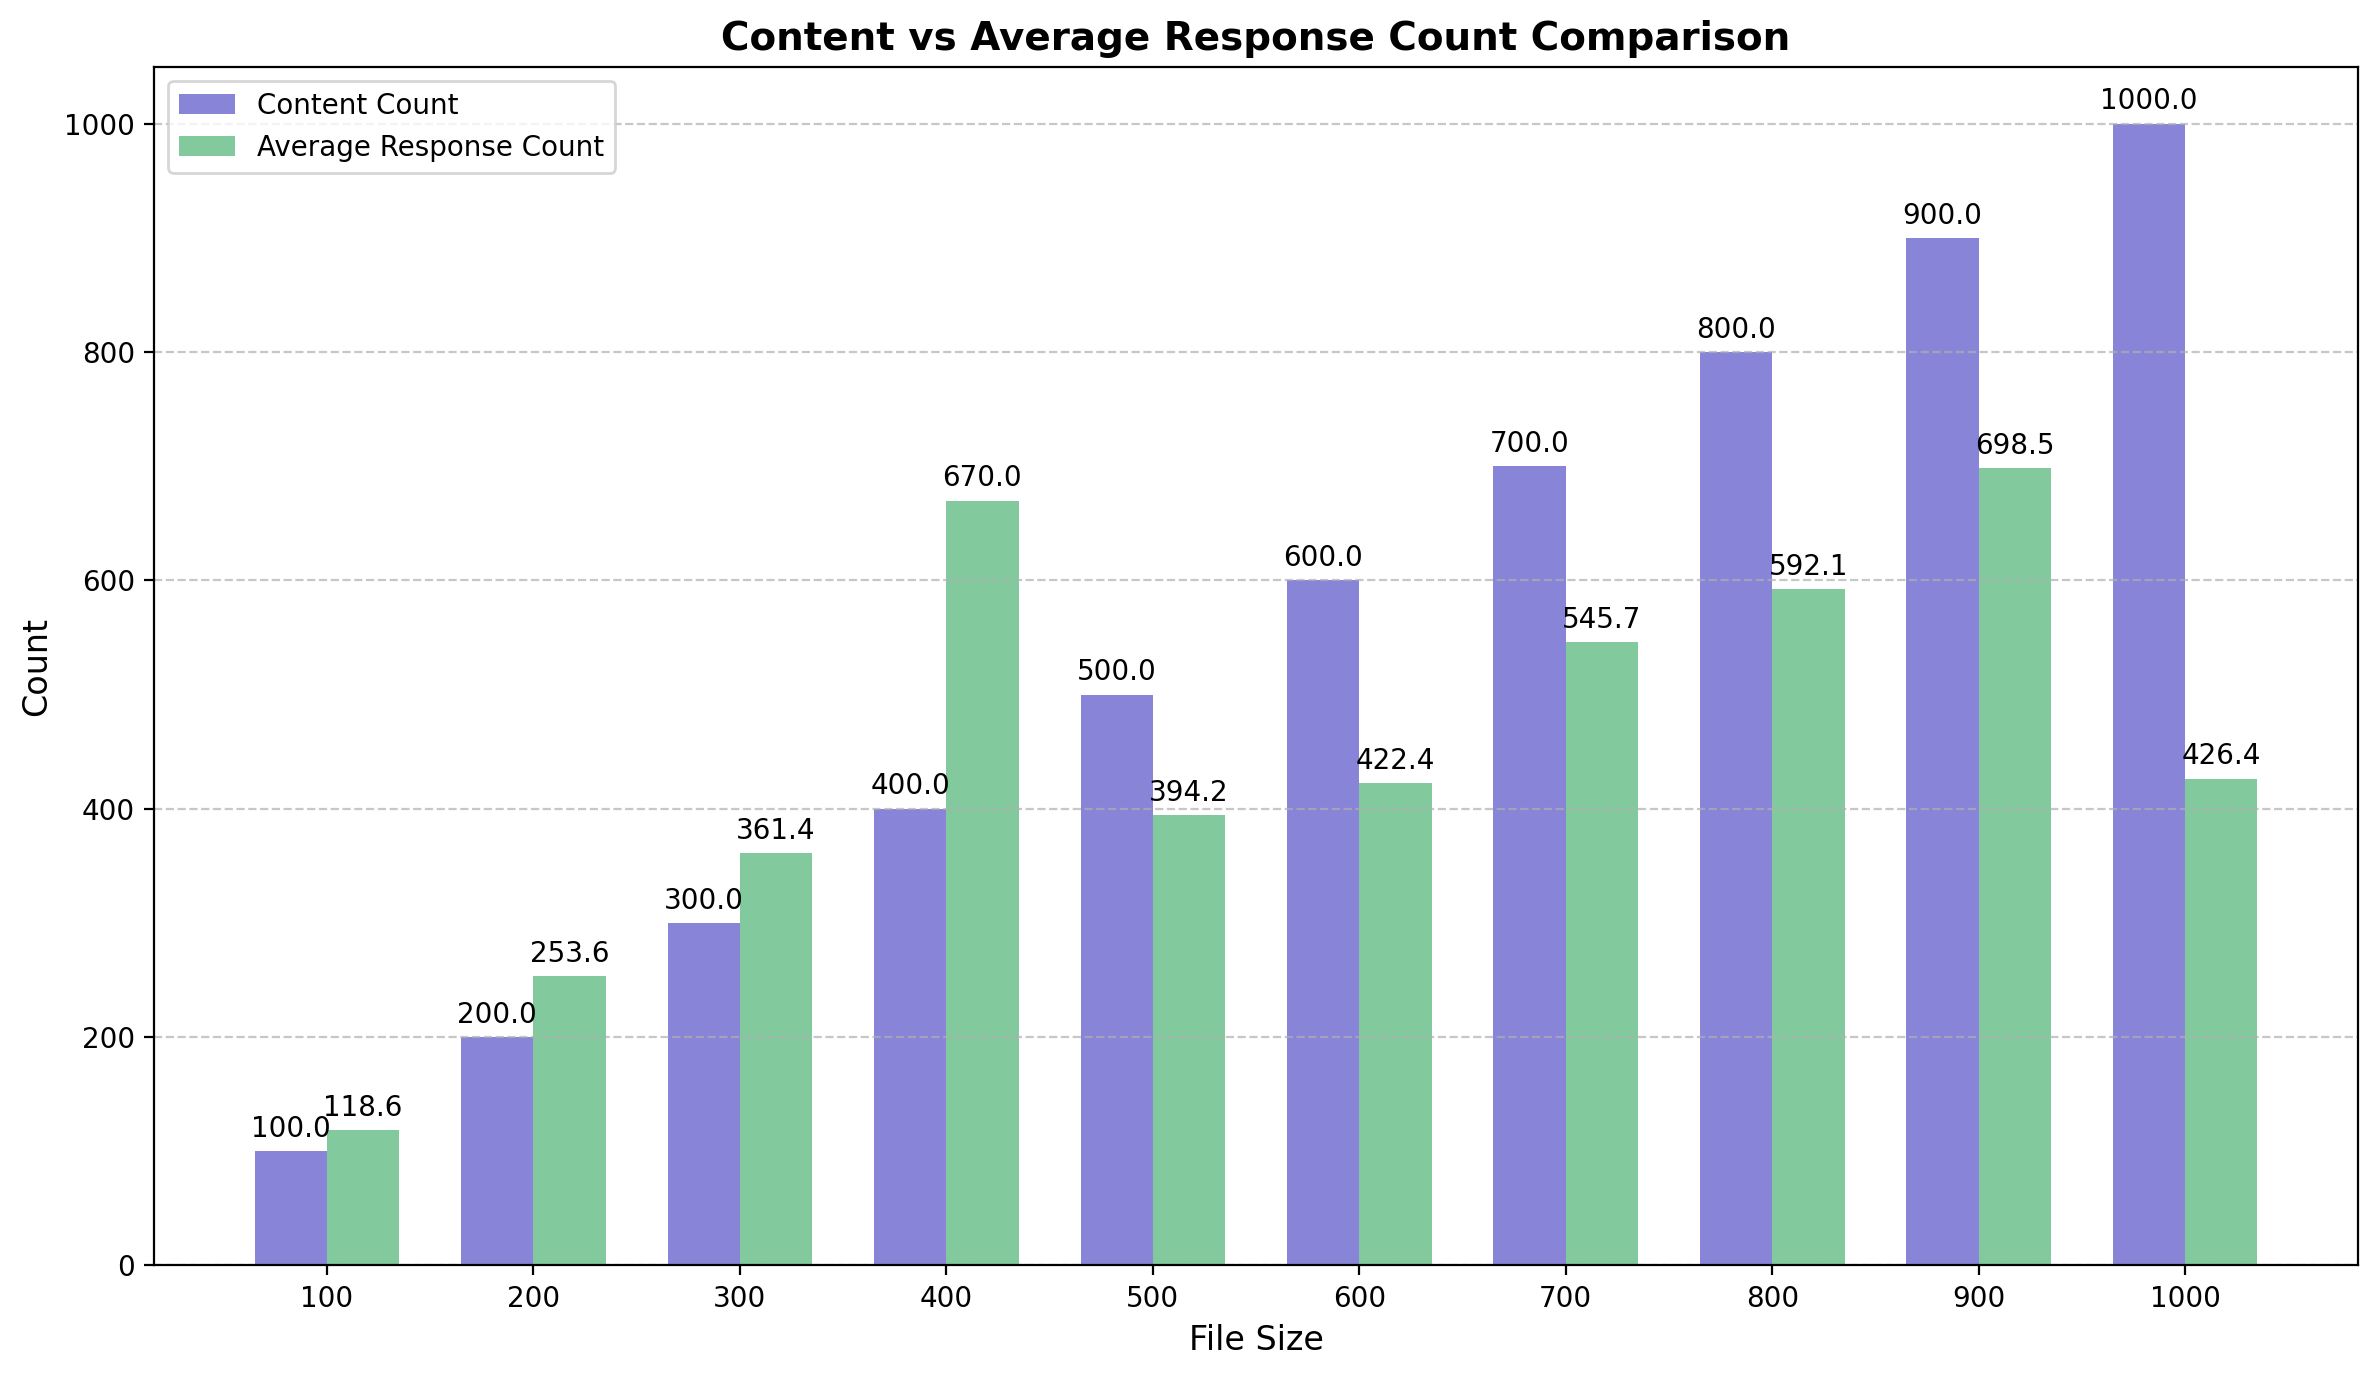

File Size | Content Count | Avg Response Count | Ratio
------------------------------------------------------------
     100 |           100 |              118.6 | 1.19
     200 |           200 |              253.6 | 1.27
     300 |           300 |              361.4 | 1.20
     400 |           400 |              670.0 | 1.68
     500 |           500 |              394.2 | 0.79
     600 |           600 |              422.4 | 0.70
     700 |           700 |              545.7 | 0.78
     800 |           800 |              592.1 | 0.74
     900 |           900 |              698.5 | 0.78
    1000 |          1000 |              426.4 | 0.43


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 정의
file_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
content_counts = file_sizes  # 파일 크기가 곧 content count
response_counts = [118.6, 253.6, 361.4, 670.0, 394.2, 422.4, 545.7, 592.1, 698.5, 426.4]

# 그래프 설정
fig, ax = plt.subplots(figsize=(12, 7))

# 막대 위치 설정
x = np.arange(len(file_sizes))
width = 0.35

# 두 개의 막대 그래프 그리기
rects1 = ax.bar(x - width/2, content_counts, width, label='Content Count', color='#8884d8')
rects2 = ax.bar(x + width/2, response_counts, width, label='Average Response Count', color='#82ca9d')

# 그래프 레이블 설정
ax.set_xlabel('File Size', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Content vs Average Response Count Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(file_sizes)
ax.legend()

# 값 표시
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

# 그리드 추가 및 레이아웃 조정
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()

# 그래프 저장 및 표시
plt.savefig('content_vs_response_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 비율 분석 출력 (선택 사항)
print("File Size | Content Count | Avg Response Count | Ratio")
print("-" * 60)
for i in range(len(file_sizes)):
    ratio = response_counts[i] / content_counts[i]
    print(f"{file_sizes[i]:8} | {content_counts[i]:13} | {response_counts[i]:18.1f} | {ratio:.2f}")